In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
from os import listdir
from os.path import isfile, join
import pymc3 as pm
import math as m
import arviz as az

import dive
import matplotlib.pyplot as plt
import deerlab as dl

from theano import tensor as T
from theano.tensor import nlinalg as tnp
from theano.tensor import slinalg as snp

In [2]:
traces = []

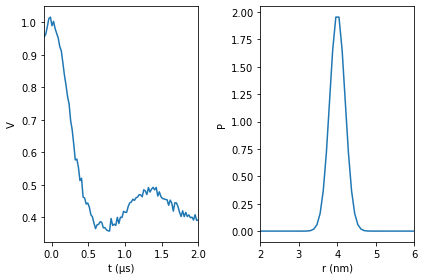

In [3]:
nr = 50
nt = 100

t = np.linspace(-0.1,2,nt)        # time axis, µs
r = np.linspace(2,6,nr)      # distance axis, ns

param = [4, 0.2] # parameters for three-Gaussian model
P0 = dl.dd_gauss(r,param)          # model distance distribution

# param2 = [4, 0.3,0.6, 4.8, 0.5, 0.4] # parameters for three-Gaussian model
# P0 = dl.dd_gauss2(r,param2)  

lam = 0.5
k = 0.1
V0 = 1                      # modulation depth

B = dive.bg_exp(t,k)         # background decay
K = dive.dipolarkernel(t,r)    # kernel matrix

Vexp = dive.deerTrace(K@P0,B,V0,lam) + dl.whitegaussnoise(t,0.01,seed=0)

fig, ax = plt.subplots(1,2)
line1 = ax[0].plot(t, Vexp)
line2 = ax[1].plot(r, P0)

ax[0].set(xlim = [min(t),max(t)], xlabel = 't (µs)', ylabel = 'V')
ax[1].set(xlim = [2,6], xlabel = 'r (nm)', ylabel = 'P')
plt.tight_layout()
plt.show()

In [4]:
L = dl.regoperator(r,d=2)

LtL = np.dot(L.transpose(),L)

KtK = np.dot(K.transpose(),K)

In [5]:
param = [5, 0.8] # parameters for three-Gaussian model
PsingleGaussOff = dl.dd_gauss(r,param)          # model distance distribution

param = [4, 0.8] # parameters for three-Gaussian model
PbroadGauss = dl.dd_gauss(r,param)          # model distance distribution

param3 = [4, 0.6,0.3, 3, 0.6, 0.3, 5.5, 0.6, 0.3] # parameters for three-Gaussian model

PmultiGauss = dl.dd_gauss3(r,param3)          # model distance distribution

param2 = [4, 0.3,0.6, 4.8, 0.5, 0.4] # parameters for three-Gaussian model
P2G = dl.dd_gauss2(r,param2)  

Puniform = np.ones(r.shape)
Puniform = Puniform/sum(Puniform)/(r[1]-r[0])

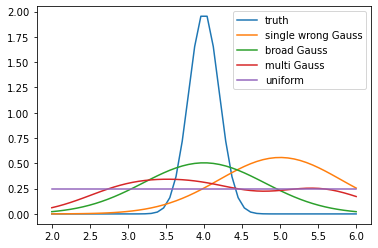

In [6]:
plt.plot(r, P0, label = "truth")
plt.plot(r, PsingleGaussOff, label = "single wrong Gauss")
plt.plot(r, PbroadGauss, label = "broad Gauss")
plt.plot(r, PmultiGauss, label = "multi Gauss")
plt.plot(r, Puniform, label = "uniform")
plt.legend()
plt.show()

## Sampling

In [8]:
Pmap = Puniform

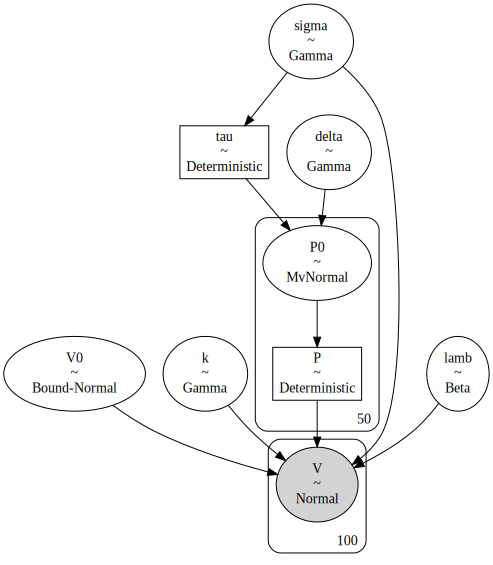

In [9]:
with pm.Model() as model:
    # Noise
    sigma = pm.Gamma('sigma', alpha=0.7, beta=2)

    #  Distribution model
    delta = pm.Gamma('delta', alpha=0.7, beta=2)

    tau = pm.Deterministic('tau',1/(sigma*sigma))
    invSigma = (tau*KtK+delta*LtL)
    # invSigma = (tau*KtK)
    Sigma = tnp.matrix_inverse(invSigma)
    C_L = snp.cholesky(Sigma)

    P0 = pm.MvNormal("P0", mu=Pmap, chol = C_L, shape = nr)        
    # P0 = pm.Bound(pm.MvNormal, lower=0.0)("P0", mu=Pmap, chol = C_L, shape = nr)  
    P = pm.Deterministic("P",P0/T.sum(P0)/(r[1]-r[0]))
    
    # Background
    k = pm.Gamma('k', alpha=0.5, beta=2)
    B = dive.bg_exp(t,k)

    # DEER Signal
    lamb = pm.Beta('lamb', alpha=1.3, beta=2.0)
    V0 = pm.Bound(pm.Normal,lower=0.0)('V0', mu=1, sigma=0.2)

    Vmodel = dive.deerTrace(pm.math.dot(K,P),B,V0,lamb)
    pm.Normal('V',mu = Vmodel, sigma = sigma, observed = Vexp)

pm.model_to_graphviz(model)

In [9]:
trace = pm.sample(model = model,chains=4, cores=4, draws=6000, tune=3000,return_inferencedata=False)
traces.append(trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [V0, lamb, k, P0, delta, sigma]


Sampling 4 chains for 3_000 tune and 5_000 draw iterations (12_000 + 20_000 draws total) took 1422 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 185 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6566490986926458, but should be close to 0.8. Try to increase the number of tuning steps.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


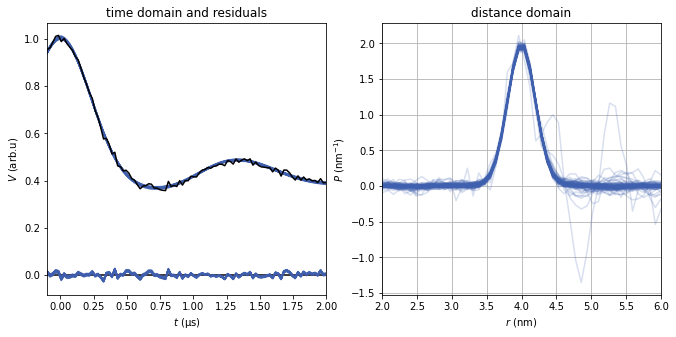

In [10]:
Ps, Vs, _, _ = dive.drawPosteriorSamples(traces[-1],r,t,100)
dive.plotMCMC(Ps,Vs,Vexp,t,r)

In [11]:
pm.save_trace(trace = trace)

'.pymc_1.trace'

In [10]:
trace = pm.load_trace('.pymc_1.trace', model=model)

mean        sd    hdi_3%    hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
k       0.098     0.005     0.089      0.106      0.000    0.000    4204.0   
λ       0.505     0.003     0.499      0.511      0.000    0.000    1597.0   
V₀      1.007     0.003     1.000      1.013      0.000    0.000    5336.0   
σ       0.010     0.001     0.009      0.011      0.000    0.000    7595.0   
τ   10305.773  1454.943  7706.058  13140.566     16.322   11.542    7595.0   
δ       0.260     0.302     0.000      0.854      0.035    0.025      76.0   

    ess_tail  r_hat  
k     9178.0   1.00  
λ     1034.0   1.00  
V₀    7907.0   1.00  
σ     7932.0   1.00  
τ     7932.0   1.00  
δ      105.0   1.07

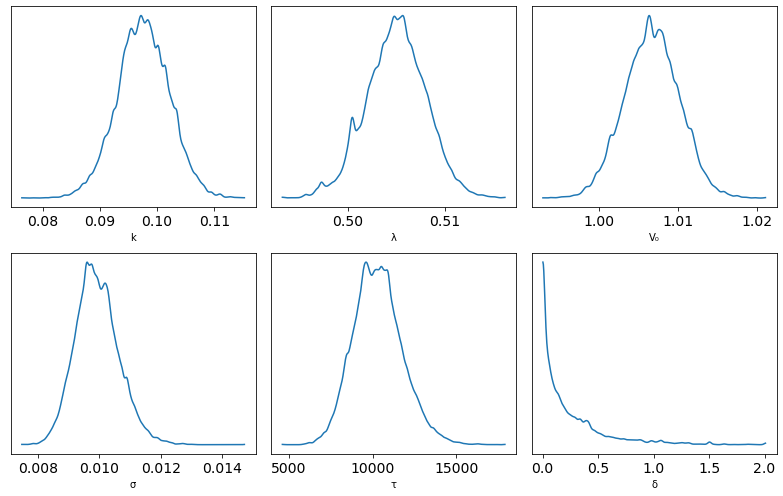

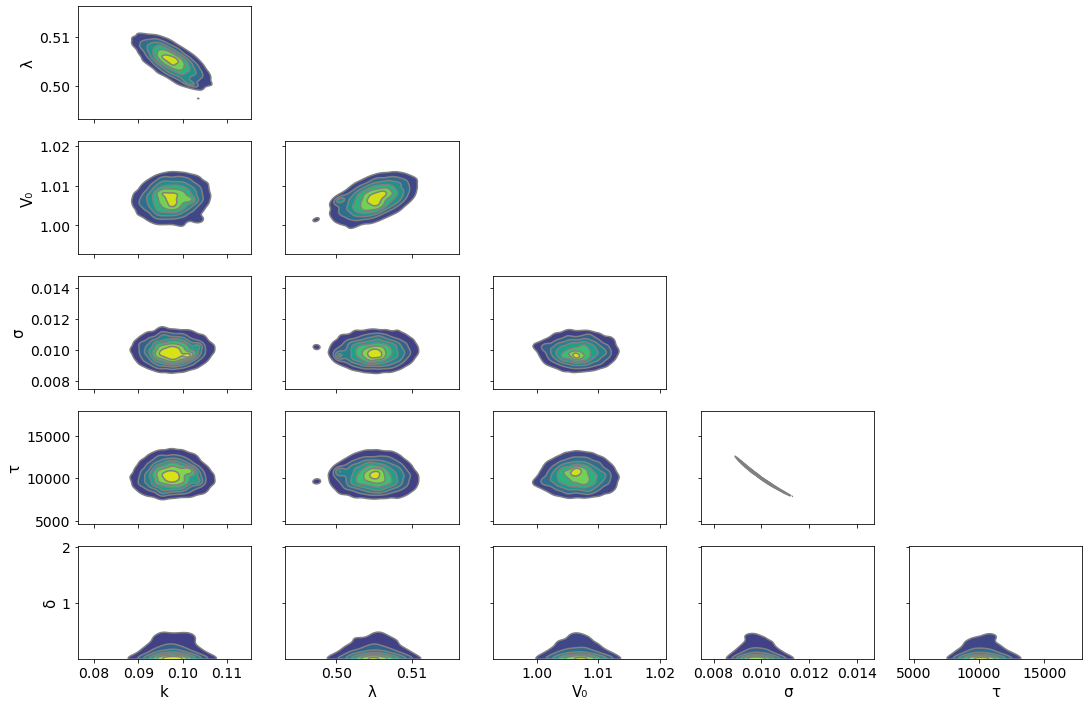

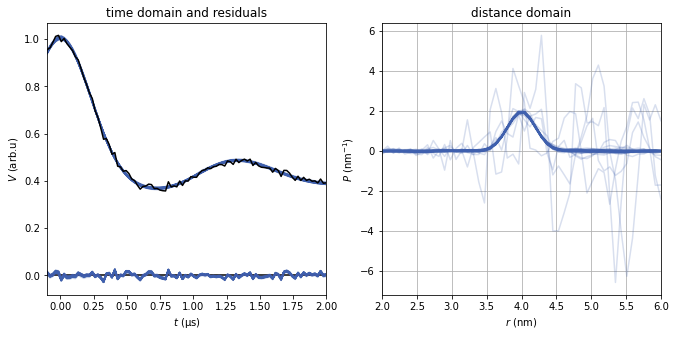

In [51]:
dive.summary(trace,model,Vexp,t,r)

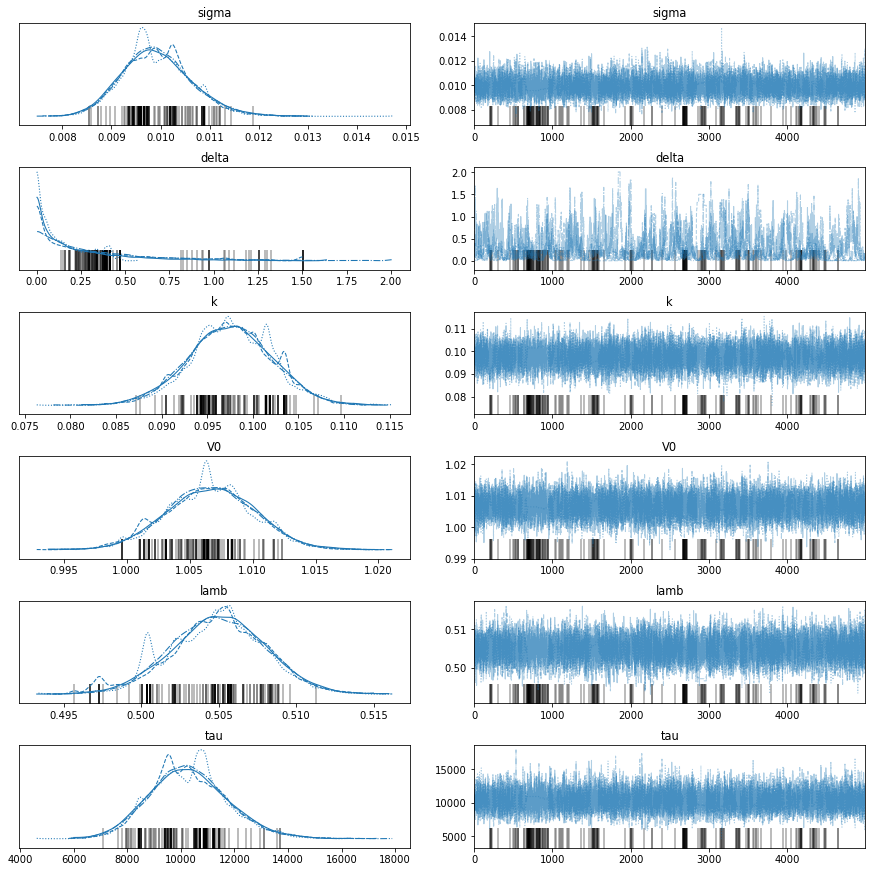

In [23]:
with model:
    az.plot_trace(trace,var_names=["sigma", "delta","k","V0","lamb","tau"])